# DRILL: Third Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
lc_df = pd.read_csv('LoanStats3d.csv', skipinitialspace=True, header=1)

In [3]:
lc_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [4]:
lc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421097 entries, 0 to 421096
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(85), object(26)
memory usage: 356.6+ MB


In [5]:
print(lc_df.columns)

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'],
      dtype='object', length=111)


In [6]:
#categorical variables 

cat = lc_df.select_dtypes(['object']).columns

print(cat)
print(len(cat))

Index(['id', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'earliest_cr_line', 'revol_util',
       'initial_list_status', 'last_pymnt_d', 'next_pymnt_d',
       'last_credit_pull_d', 'application_type', 'verification_status_joint'],
      dtype='object')
26


In [7]:
#numeric variables 

num = lc_df.select_dtypes(['int64', 'float64']).columns

print(num)
print(len(num))

Index(['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint',
       'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amn

In [8]:
#convert id and interest rate to numeric 

lc_df['id'] = pd.to_numeric(lc_df['id'], errors='coerce')
lc_df['int_rate'] = pd.to_numeric(lc_df['int_rate'].astype(str).str.strip('%'), errors='coerce')

#drop other columns with many unique variables
lc_df.drop(['url', 'zip_code', 'earliest_cr_line', 'revol_util',
         'sub_grade', 'addr_state', 'last_pymnt_d', 'last_credit_pull_d',
         'issue_d', 'pymnt_plan'], 1, inplace=True)

lc_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401.0,72868139.0,16000.0,16000.0,16000.0,60 months,14.85,379.39,C,Bookkeeper/Accounting,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783.0,73244544.0,9600.0,9600.0,9600.0,36 months,7.49,298.58,A,tech,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916.0,73356753.0,25000.0,25000.0,25000.0,36 months,7.49,777.55,A,Sales Manager,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961.0,73356799.0,28000.0,28000.0,28000.0,36 months,6.49,858.05,A,Senior Manager,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092.0,73384866.0,8650.0,8650.0,8650.0,36 months,19.89,320.99,E,Program Coordinator,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [9]:
total_missing = lc_df.isnull().sum().sort_values(ascending=False)
percent_missing = (lc_df.isnull().sum()/lc_df.isnull().count()*100).sort_values(ascending=False)

percent_missing

desc                              99.989314
dti_joint                         99.879125
verification_status_joint         99.878650
annual_inc_joint                  99.878650
il_util                           95.578928
mths_since_rcnt_il                95.058146
total_cu_tl                       94.924685
inq_last_12m                      94.924685
open_rv_12m                       94.924685
open_acc_6m                       94.924685
inq_fi                            94.924685
open_rv_24m                       94.924685
total_bal_il                      94.924685
open_il_24m                       94.924685
open_il_12m                       94.924685
max_bal_bc                        94.924685
open_il_6m                        94.924685
all_util                          94.924685
mths_since_last_record            82.328300
mths_since_recent_bc_dlq          74.210218
mths_since_last_major_derog       70.854934
mths_since_recent_revol_delinq    63.966260
mths_since_last_delinq          

In [10]:
missing = pd.concat([total_missing, percent_missing], axis=1, keys=['Total_missing', 'Percent_missing'])
var = missing[missing['Percent_missing'] < 1].index
var

Index(['bc_open_to_buy', 'mths_since_recent_bc', 'title', 'num_rev_accts',
       'out_prncp_inv', 'total_pymnt_inv', 'total_rec_prncp', 'total_pymnt',
       'total_rec_int', 'initial_list_status', 'out_prncp', 'open_acc',
       'total_acc', 'home_ownership', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'annual_inc', 'revol_bal', 'verification_status', 'loan_status',
       'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'recoveries',
       'pub_rec', 'total_rec_late_fee', 'total_il_high_credit_limit',
       'collection_recovery_fee', 'last_pymnt_amnt', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
       'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'pub_rec_bankruptcies',
       'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'num_actv_bc_tl',
       'num_accts_ever_120_pd', 'mort_acc', 'to

In [14]:
#select those variables with only less than 1% missing then drop NaNs 
lc = lc_df[var]
lc.head()

,bc_open_to_buy,mths_since_recent_bc,title,num_rev_accts,out_prncp_inv,total_pymnt_inv,total_rec_prncp,total_pymnt,total_rec_int,initial_list_status,...,tot_cur_bal,total_rev_hi_lim,mo_sin_rcnt_tl,acc_open_past_24mths,avg_cur_bal,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,id
0,263953.0,11.0,Credit card refinancing,11.0,13668.88,4519.68,2331.12,4519.68,2188.56,w,...,31329.0,284700.0,6.0,6.0,2848.0,0.0,0.0,294.0,11.0,68009401.0
1,4778.0,11.0,Credit card refinancing,4.0,6635.69,3572.97,2964.31,3572.97,608.66,w,...,55387.0,13000.0,9.0,2.0,7912.0,0.0,0.0,91.0,9.0,68354783.0
2,17538.0,13.0,Debt consolidation,9.0,0.00,26224.23,25000.00,26224.23,1224.23,w,...,305781.0,38400.0,13.0,2.0,33976.0,0.0,0.0,168.0,13.0,68466916.0
3,16623.0,19.0,Debt consolidation,18.0,19263.77,10271.36,8736.23,10271.36,1535.13,w,...,221110.0,79900.0,19.0,1.0,13819.0,0.0,0.0,379.0,19.0,68466961.0
4,1375.0,8.0,Debt consolidation,17.0,0.00,9190.49,8650.00,9190.49,540.49,w,...,18926.0,20750.0,0.0,17.0,1051.0,0.0,0.0,95.0,0.0,68495092.0


In [15]:
lc = lc.dropna(axis=0)
lc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416925 entries, 0 to 421094
Data columns (total 70 columns):
bc_open_to_buy                416925 non-null float64
mths_since_recent_bc          416925 non-null float64
title                         416925 non-null object
num_rev_accts                 416925 non-null float64
out_prncp_inv                 416925 non-null float64
total_pymnt_inv               416925 non-null float64
total_rec_prncp               416925 non-null float64
total_pymnt                   416925 non-null float64
total_rec_int                 416925 non-null float64
initial_list_status           416925 non-null object
out_prncp                     416925 non-null float64
open_acc                      416925 non-null float64
total_acc                     416925 non-null float64
home_ownership                416925 non-null object
member_id                     416925 non-null float64
loan_amnt                     416925 non-null float64
funded_amnt                 

In [16]:
lc['loan_status'].isnull().sum()

0

In [17]:
cat = lc.select_dtypes(['object']).columns

print(cat)

Index(['title', 'initial_list_status', 'home_ownership', 'term', 'grade',
       'verification_status', 'loan_status', 'purpose', 'application_type'],
      dtype='object')


In [18]:
lc.isna().sum()

bc_open_to_buy                0
mths_since_recent_bc          0
title                         0
num_rev_accts                 0
out_prncp_inv                 0
total_pymnt_inv               0
total_rec_prncp               0
total_pymnt                   0
total_rec_int                 0
initial_list_status           0
out_prncp                     0
open_acc                      0
total_acc                     0
home_ownership                0
member_id                     0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
annual_inc                    0
revol_bal                     0
verification_status           0
loan_status                   0
purpose                       0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
                             ..
num_op_r

In [19]:
print(lc.isnull().sum())

bc_open_to_buy                0
mths_since_recent_bc          0
title                         0
num_rev_accts                 0
out_prncp_inv                 0
total_pymnt_inv               0
total_rec_prncp               0
total_pymnt                   0
total_rec_int                 0
initial_list_status           0
out_prncp                     0
open_acc                      0
total_acc                     0
home_ownership                0
member_id                     0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
annual_inc                    0
revol_bal                     0
verification_status           0
loan_status                   0
purpose                       0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
                             ..
num_op_r

In [20]:
cat = lc.select_dtypes(['object']).columns

print(cat)

Index(['title', 'initial_list_status', 'home_ownership', 'term', 'grade',
       'verification_status', 'loan_status', 'purpose', 'application_type'],
      dtype='object')


In [21]:
cat_feats = ['title', 'initial_list_status',
             'home_ownership', 'term', 'grade', 'verification_status',
             'purpose', 'application_type']

final_data = pd.get_dummies(lc,columns=cat_feats,
                            drop_first=True)

final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416925 entries, 0 to 421094
Columns: 115 entries, bc_open_to_buy to application_type_JOINT
dtypes: float64(61), object(1), uint8(53)
memory usage: 221.5+ MB


In [22]:
final_data.head()

,bc_open_to_buy,mths_since_recent_bc,num_rev_accts,out_prncp_inv,total_pymnt_inv,total_rec_prncp,total_pymnt,total_rec_int,out_prncp,open_acc,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_JOINT
0,263953.0,11.0,11.0,13668.88,4519.68,2331.12,4519.68,2188.56,13668.88,11.0,...,0,0,0,0,0,0,0,0,0,0
1,4778.0,11.0,4.0,6635.69,3572.97,2964.31,3572.97,608.66,6635.69,7.0,...,0,0,0,0,0,0,0,0,0,0
2,17538.0,13.0,9.0,0.00,26224.23,25000.00,26224.23,1224.23,0.00,9.0,...,0,0,0,0,0,0,0,0,0,0
3,16623.0,19.0,18.0,19263.77,10271.36,8736.23,10271.36,1535.13,19263.77,16.0,...,0,0,0,0,0,0,0,0,0,0
4,1375.0,8.0,17.0,0.00,9190.49,8650.00,9190.49,540.49,0.00,18.0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#use PCA for dimensionality reduction 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = final_data.drop('loan_status', 1)

X = StandardScaler().fit_transform(X)

pca = PCA(n_components=50)
principalComponents = pca.fit_transform(X)

var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)

print(
    'The percent of total variance in the dataset explained by each',
    'component from Sklearn PCA:\n',
    np.round(pca.explained_variance_ratio_, decimals=3)*100
)

print(
    'The cumulative sum of variance explained:',
    var
)

The percent of total variance in the dataset explained by each component from Sklearn PCA:
 [9.8 5.8 3.9 3.3 3.2 2.7 2.2 2.1 2.  1.9 1.8 1.8 1.8 1.8 1.8 1.8 1.8 1.7
 1.7 1.7 1.6 1.5 1.4 1.3 1.2 1.2 1.  1.  1.  1.  0.9 0.9 0.9 0.9 0.9 0.9
 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
The cumulative sum of variance explained: [ 9.8 15.6 19.5 22.8 26.  28.7 30.9 33.  35.  36.9 38.7 40.5 42.3 44.1
 45.9 47.7 49.5 51.2 52.9 54.6 56.2 57.7 59.1 60.4 61.6 62.8 63.8 64.8
 65.8 66.8 67.7 68.6 69.5 70.4 71.3 72.2 73.1 74.  74.9 75.8 76.7 77.6
 78.5 79.4 80.3 81.2 82.1 83.  83.9 84.8]


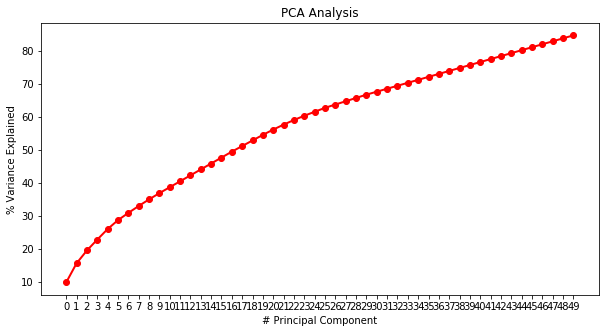

In [24]:
fig = plt.figure(figsize=(10,5))
sing_vals = np.arange(0, pca.n_components_, 1)
plt.plot(sing_vals, var, 'ro-', linewidth=2)
plt.title('PCA Analysis')
plt.xticks(np.arange(0,50,1))
plt.xlabel('# Principal Component')
plt.ylabel('% Variance Explained')
plt.show()

In [25]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = final_data.drop('loan_status', 1)
Y = final_data['loan_status']

cross_val_score(rfc, X, Y, cv=10)

array([0.96133829, 0.96363985, 0.96215283, 0.96167314, 0.96128939,
       0.96152831, 0.96075986, 0.9607829 , 0.96054115, 0.9598935 ])

In [27]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416925 entries, 0 to 421094
Columns: 115 entries, bc_open_to_buy to application_type_JOINT
dtypes: float64(61), object(1), uint8(53)
memory usage: 241.5+ MB


In [26]:
colname = []
for i in range(1,51):
    colname.append('pc' + str(i))
    
principalDF = pd.DataFrame(data=principalComponents, columns = colname)
finalDF = pd.concat([final_data['loan_status'],principalDF], axis=1)
finalDF.head(20)

,loan_status,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50
0,Current,6.012995,1.867611,6.448112,-4.963901,0.484055,1.874073,2.554103,-2.875952,0.793351,...,0.010798,-0.260929,0.095432,-1.040431,0.127611,0.576910,-0.144155,1.726536,2.273564,-0.973720
1,Current,-3.396200,-0.629733,2.702066,-1.350646,0.954940,-1.255708,-1.154853,-0.705372,-1.774837,...,-0.020175,-0.027960,-0.004048,0.006479,0.024178,0.163757,-0.033510,-0.048883,0.136807,0.058436
2,Fully Paid,2.209061,-4.303307,0.793749,1.404226,-3.706641,1.627486,-0.665272,-0.874652,-1.549057,...,-0.030589,-0.000757,0.018465,0.052022,-0.041884,0.032802,-0.080100,-0.070602,0.177131,0.208375
3,Current,4.271586,-1.070330,1.353375,-2.062912,1.755767,3.104890,0.972752,0.017759,0.077765,...,0.001328,-0.007274,0.033971,0.062057,-0.020432,0.052859,-0.055474,-0.147439,-0.121503,0.072143
4,Fully Paid,-0.092846,5.492454,-4.741101,1.301653,-0.687796,-1.529516,-0.074033,-2.175003,-2.363097,...,0.144996,0.099655,-0.103042,0.447940,-0.234475,0.046236,0.076849,0.490321,-0.128676,-0.336578
5,Current,2.244215,1.339139,1.554609,-3.771329,2.382706,-1.243207,-1.245459,1.462067,-1.409277,...,-0.027002,-0.039056,0.015724,-0.119569,-0.064535,-0.035090,-0.018687,0.105825,-0.055746,-0.194227
6,Current,3.420857,-1.324466,-1.324954,-0.727007,3.507604,0.945589,0.396434,-1.390102,-1.357336,...,0.024481,-0.022661,0.003734,-0.000432,0.093476,-0.048846,-0.054620,0.027655,-0.106203,-0.105408
7,Fully Paid,3.977344,0.915450,0.736740,0.331966,-2.784774,2.149677,0.706249,-1.741610,-0.962335,...,-0.039615,-0.068823,-0.012675,-0.166994,-0.002750,0.012295,0.113060,0.439578,0.278959,-0.139595
8,Current,4.361030,-3.138444,-0.761548,-2.319975,3.482574,1.664011,0.880084,-1.778734,-0.956954,...,-0.026402,-0.044801,0.003361,-0.078119,0.067418,0.066789,-0.151987,0.146480,0.051535,0.091517
9,Fully Paid,1.358884,0.693087,0.314447,3.595019,0.200523,-3.158236,-0.025651,-1.983205,-0.234812,...,-0.076145,0.016706,-0.005160,0.067736,-0.227255,-0.079152,0.492378,0.233964,0.276966,0.999506


In [53]:
finalDF['loan_status'].isnull()

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10         True
11        False
12        False
13        False
14        False
15        False
16         True
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
421065    False
421066    False
421067    False
421068    False
421069    False
421070    False
421071    False
421072    False
421073    False
421074    False
421075    False
421076    False
421077    False
421078    False
421079    False
421080    False
421081    False
421082    False
421083    False
421084    False
421085    False
421086    False
421087    False
421088    False
421089    False
421090    False
421091    False
421092    False
421093    False
421094    False
Name: loan_status, Lengt

In [46]:
finalDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421059 entries, 0 to 421094
Data columns (total 51 columns):
loan_status    416925 non-null object
pc1            416925 non-null float64
pc2            416925 non-null float64
pc3            416925 non-null float64
pc4            416925 non-null float64
pc5            416925 non-null float64
pc6            416925 non-null float64
pc7            416925 non-null float64
pc8            416925 non-null float64
pc9            416925 non-null float64
pc10           416925 non-null float64
pc11           416925 non-null float64
pc12           416925 non-null float64
pc13           416925 non-null float64
pc14           416925 non-null float64
pc15           416925 non-null float64
pc16           416925 non-null float64
pc17           416925 non-null float64
pc18           416925 non-null float64
pc19           416925 non-null float64
pc20           416925 non-null float64
pc21           416925 non-null float64
pc22           416925 non-null f

In [44]:
rfc = ensemble.RandomForestClassifier()
X = finalDF.drop('loan_status', 1)
Y = finalDF['loan_status']

cross_val_score(rfc, X, Y, cv=10)

TypeError: '<' not supported between instances of 'float' and 'str'

In [49]:
finalDF.isnull().sum()

loan_status    4134
pc1            4134
pc2            4134
pc3            4134
pc4            4134
pc5            4134
pc6            4134
pc7            4134
pc8            4134
pc9            4134
pc10           4134
pc11           4134
pc12           4134
pc13           4134
pc14           4134
pc15           4134
pc16           4134
pc17           4134
pc18           4134
pc19           4134
pc20           4134
pc21           4134
pc22           4134
pc23           4134
pc24           4134
pc25           4134
pc26           4134
pc27           4134
pc28           4134
pc29           4134
pc30           4134
pc31           4134
pc32           4134
pc33           4134
pc34           4134
pc35           4134
pc36           4134
pc37           4134
pc38           4134
pc39           4134
pc40           4134
pc41           4134
pc42           4134
pc43           4134
pc44           4134
pc45           4134
pc46           4134
pc47           4134
pc48           4134
pc49           4134
